# Kaggle Competition: Novozymes Enzyme Stability Prediction, Help identify the thermostable mutations in enzymes

by: Tianxiong Yu, upload at <b><a href="https://github.com/Lecter314/MLDM_2022_YuTianxiong_EEP/tree/main/Novozymes%20Enzyme%20Stability%20Prediction">github_MLDM_2022_YuTianxiong_EEP</a></b>

## 4 Fitting the model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_updated = pd.read_csv("/content/drive/MyDrive/after intermediate/data_updated.csv")
data_test = pd.read_csv("/content/drive/MyDrive/after intermediate/data_test.csv")

In [6]:
X_backup = data_updated.copy()

In [7]:
X = X_backup.drop(columns=["seq_id", "tm","protein_sequence"])
y = X_backup["tm"]

In [8]:
X.head()

,pH,data_source,A,C,D,E,F,G,H,I,...,SSG,SSL,SSS,TLL,VAA,VLA,VLL,wildtype,mutation,position
0,7.0,1,45,1,13,30,13,38,3,14,...,0,0,0,0,0,0,0,4.2,1.8,1
1,7.0,1,28,0,10,52,6,18,4,13,...,0,0,0,0,0,0,1,4.2,1.8,1
2,7.0,1,50,9,27,32,21,65,11,16,...,0,0,0,0,0,0,0,4.2,1.8,1
3,7.0,1,20,5,19,29,12,16,7,10,...,0,0,0,0,0,0,0,4.2,1.8,1
4,7.0,1,86,14,78,78,32,84,40,71,...,1,2,3,0,1,0,1,4.2,1.8,1


In [9]:
y.head()

0    75.7
1    50.5
2    40.5
3    47.2
4    49.5
Name: tm, dtype: float64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42) # y_test for validation

### 4.1 baseline

#### 4.1.1 some basic models

In [ ]:
# start with some basic models
models = [("knn", KNeighborsRegressor()), ("rf", RandomForestRegressor()), ("svm", SVR()),
          ("lr", LinearRegression()), ("lgbm", LGBMRegressor()), ("xgb", XGBRegressor())
         ]

results = []
names = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=3, shuffle=True, random_state=42)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring="r2") # notice from here we train the avarall dataset
    names.append(name)
    results.append(cv_results)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


knn: 0.508986 (0.004035)
rf: 0.566654 (0.001959)
svm: 0.067301 (0.001067)
lr: 0.228962 (0.004802)
lgbm: 0.557775 (0.001917)
xgb: 0.540825 (0.005657)


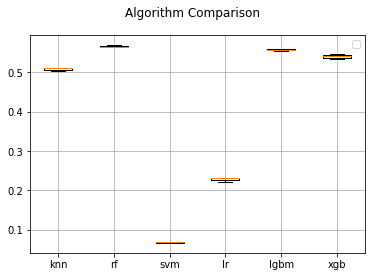

In [ ]:
# boxplot algorithm comparison, indicates svm and lr may not be a good fit
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.grid()
plt.legend()
plt.show()

#### 4.1.2 searching better hyperparameters for each model

In [119]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # maybe RandomizedSearchCV can boost searching speed

In [ ]:
# for model comparison
comparison = pd.DataFrame(columns={"RF", "LGBM", "XGB", "KNN"}, index={"best_params", "R2", "MSE", "MAE"})

def write_comparison(model_name, best_params, r2, mse, mae):
    comparison.loc["best_params", model_name] = str(best_params)
    comparison.loc["R2", model_name] = r2
    comparison.loc["MSE", model_name] = mse
    comparison.loc["MAE", model_name] = mae
    return comparison


In [ ]:
# test model performance in test dataset
def evaluation_criteria(y_test, y_pred):
    r2 = metrics.r2_score(y_test, y_pred)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    return r2, mae, mse

In [ ]:
# rf
rf = RandomForestRegressor()

param_grid_rf = {
    'n_estimators': np.arange(100, 300, step=50),
    'max_depth': list(np.arange(5, 30, step=10)),
}

# cv=5
gs_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring="neg_mean_squared_error", # using another optim
                              cv=5, verbose=0, n_jobs=-1,
                              return_train_score=True)
gs_rf.fit(X_train,y_train)

best_estimator_rf = gs_rf.best_estimator_
best_params_rf = gs_rf.best_params_


y_pred_rf= gs_rf.predict(X_test)

In [ ]:
r2_rf, mae_rf, mse_rf = evaluation_criteria(y_test, y_pred_rf)

print("best params: ", best_params_rf)
print(r2_rf, mae_rf, mse_rf)

best params:  {'max_depth': 25, 'n_estimators': 250}
0.5697359594803302 5.714212561366392 61.8132445901266


In [ ]:
comparison = write_comparison("RF", best_params_rf, r2_rf, mse_rf, mae_rf)
comparison

,LGBM,RF,XGB,KNN
best_params,NaN,"{'max_depth': 25, 'n_estimators': 250}",NaN,NaN
MSE,NaN,61.813245,NaN,NaN
MAE,NaN,5.714213,NaN,NaN
R2,NaN,0.569736,NaN,NaN


In [120]:
# lgbm
lgbm = LGBMRegressor()
param_grid_lgbm = {
    'n_estimators': np.arange(100, 300, step=50),
    'num_leaves': np.arange(50, 300, step=50),
    'learning_rate': list(np.arange(0.05, 0.2, 0.05))
}

# cv=5
gs_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid_lgbm, scoring="neg_mean_squared_error", # using another optim
                              cv=5, verbose=0, n_jobs=-1,
                              return_train_score=True)
gs_lgbm.fit(X_train,y_train)

best_estimator_lgbm = gs_lgbm.best_estimator_
best_params_lgbm = gs_lgbm.best_params_



In [ ]:
y_pred_lgbm= gs_lgbm.predict(X_test)

In [ ]:
r2_lgbm, mae_lgbm, mse_lgbm = evaluation_criteria(y_test, y_pred_lgbm)

print("best params: ", best_params_lgbm)
print(r2_lgbm, mae_lgbm, mse_lgbm)

best params:  {'learning_rate': 0.05, 'n_estimators': 250, 'num_leaves': 250}
0.5976281411533484 5.564431072889873 57.806155720175596


In [ ]:
comparison = write_comparison("LGBM", best_params_lgbm, r2_lgbm, mse_lgbm, mae_lgbm)
comparison

,LGBM,RF,XGB,KNN
best_params,"{'learning_rate': 0.05, 'n_estimators': 250, '...","{'max_depth': 25, 'n_estimators': 250}",NaN,NaN
MSE,57.806156,61.813245,NaN,NaN
MAE,5.564431,5.714213,NaN,NaN
R2,0.597628,0.569736,NaN,NaN


In [ ]:
# XGBoost
xgb = XGBRegressor()

param_grid_xgb = {
      "learning_rate": list(np.arange(0.05, 0.2, 0.05)),
      "n_estimators": [100, 200]
}

gs_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, n_jobs=-1, verbose=1, return_train_score=True)

gs_xgb.fit(X_train, y_train)

best_estimator_xgb = gs_xgb.best_estimator_
best_params_xgb = gs_xgb.best_params_

y_pred_xgb= gs_xgb.predict(X_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [ ]:
r2_xgb, mae_xgb, mse_xgb = evaluation_criteria(y_test, y_pred_xgb)

print("best params: ", best_params_xgb)
print(r2_xgb, mae_xgb, mse_xgb)

best params:  {'learning_rate': 0.1, 'n_estimators': 200}
0.5786731324851204 5.776449682840058 60.529298898959496


In [ ]:
comparison = write_comparison("XGB", best_params_xgb, r2_xgb, mse_xgb, mae_xgb)
comparison

,RF,XGB,LGBM,KNN
R2,0.569736,0.578673,0.597628,NaN
best_params,"{'max_depth': 25, 'n_estimators': 250}","{'learning_rate': 0.1, 'n_estimators': 200}","{'learning_rate': 0.05, 'n_estimators': 250, '...",NaN
MSE,61.813245,60.529299,57.806156,NaN
MAE,5.714213,5.77645,5.564431,NaN


In [ ]:
# knn
knn = KNeighborsRegressor()

param_grid_knn = {
    "n_neighbors": [3, 5, 10, 20], 
    "weights": ["uniform","distance"]}

gs_knn = GridSearchCV(knn, param_grid_knn, cv=5, n_jobs=-1, verbose=1, return_train_score=True)

gs_knn.fit(X_train, y_train)

best_estimator_knn = gs_knn.best_estimator_
best_params_knn = gs_knn.best_params_

y_pred_knn= gs_knn.predict(X_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [ ]:
r2_knn, mae_knn, mse_knn = evaluation_criteria(y_test, y_pred_knn)

print("best params: ", best_params_knn)
print(r2_knn, mae_knn, mse_knn)

best params:  {'n_neighbors': 10, 'weights': 'distance'}
0.5212624592529533 5.943662333077348 68.77711803415293


In [ ]:
# after tuning, together considering MSE, MAE and R2, LGBM in such senarios performs the best in prediction
comparison = write_comparison("KNN", best_params_knn, r2_knn, mse_knn, mae_knn)
comparison

,RF,XGB,LGBM,KNN
R2,0.569736,0.578673,0.597628,0.521262
best_params,"{'max_depth': 25, 'n_estimators': 250}","{'learning_rate': 0.1, 'n_estimators': 200}","{'learning_rate': 0.05, 'n_estimators': 250, '...","{'n_neighbors': 10, 'weights': 'distance'}"
MSE,61.813245,60.529299,57.806156,68.777118
MAE,5.714213,5.77645,5.564431,5.943662


In [ ]:
# save these models
import pickle
pickle.dump(gs_rf, open('gs_rf.sav', 'wb'))
pickle.dump(gs_lgbm, open('gs_lgbm.sav', 'wb'))
pickle.dump(gs_xgb, open('gs_xgb.sav', 'wb'))
pickle.dump(gs_knn, open('gs_knn.sav', 'wb'))

### 4.2 ensemble approach

In [ ]:
passlist = X_train.columns.values.tolist()
for i in ["pH", "length", "kinds", "position", "wildtype", "mutation"]:
    passlist.remove(i)

In [ ]:
# considering to ensemble two models, first try combine knn and lgbm, with fast processing speed for trial
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingRegressor

knn_pipeline = make_pipeline(make_column_transformer(("passthrough", ["pH", "length", "kinds", "position", "wildtype", "mutation"])), knn)
lgbm_pipeline = make_pipeline(make_column_transformer(("passthrough", passlist)), lgbm)

estimators = [
    ('kNN', knn_pipeline),
    ('LGBM', lgbm_pipeline)
]

clf = StackingRegressor(
    estimators=estimators, final_estimator=LinearRegression(), cv=5
)
clf

StackingRegressor(cv=5,
                  estimators=[('kNN',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('passthrough',
                                                                                 'passthrough',
                                                                                 ['pH',
                                                                                  'length',
                                                                                  'kinds',
                                                                                  'position',
                                                                                  'wildtype',
                                                                                  'mutation'])])),
                                               ('kneighborsregressor',
                                                

In [ ]:
# check which of the keys can be modified
clf.get_params().keys()

dict_keys(['cv', 'estimators', 'final_estimator__copy_X', 'final_estimator__fit_intercept', 'final_estimator__n_jobs', 'final_estimator__normalize', 'final_estimator__positive', 'final_estimator', 'n_jobs', 'passthrough', 'verbose', 'kNN', 'LGBM', 'kNN__memory', 'kNN__steps', 'kNN__verbose', 'kNN__columntransformer', 'kNN__kneighborsregressor', 'kNN__columntransformer__n_jobs', 'kNN__columntransformer__remainder', 'kNN__columntransformer__sparse_threshold', 'kNN__columntransformer__transformer_weights', 'kNN__columntransformer__transformers', 'kNN__columntransformer__verbose', 'kNN__columntransformer__verbose_feature_names_out', 'kNN__columntransformer__passthrough', 'kNN__kneighborsregressor__algorithm', 'kNN__kneighborsregressor__leaf_size', 'kNN__kneighborsregressor__metric', 'kNN__kneighborsregressor__metric_params', 'kNN__kneighborsregressor__n_jobs', 'kNN__kneighborsregressor__n_neighbors', 'kNN__kneighborsregressor__p', 'kNN__kneighborsregressor__weights', 'LGBM__memory', 'LGBM_

In [ ]:
# also find better hyperparameters for ensembles
# why not Randomized Search for faster processing
param_grid_ensem = dict(
        kNN__kneighborsregressor__n_neighbors = [3, 5, 10, 20],
        kNN__kneighborsregressor__weights = ["uniform","distance"],
        LGBM__lgbmregressor__n_estimators = np.arange(100, 300, step=50),
        LGBM__lgbmregressor__num_leaves = np.arange(50, 300, step=50),
        LGBM__lgbmregressor__learning_rate =  list(np.arange(0.05, 0.2, 0.05))
        )

# gs_ensem = GridSearchCV(clf, param_grid=param_grid_ensem) # even 
gs_ensem = RandomizedSearchCV(clf, param_distributions=param_grid_ensem) # switch to random search because grid is toooooo time consuming, be careful about the variables
gs_ensem.fit(X_train,y_train)

best_estimator_ensem = gs_ensem.best_estimator_
best_params_ensem = gs_ensem.best_params_

y_pred_ensem= gs_ensem.predict(X_test)

In [ ]:
r2_ensem, mae_ensem, mse_ensem = evaluation_criteria(y_test, y_pred_ensem)

print("best params: ", best_params_ensem)
print(r2_ensem, mae_ensem, mse_ensem)

best params:  {'kNN__kneighborsregressor__weights': 'distance', 'kNN__kneighborsregressor__n_neighbors': 3, 'LGBM__lgbmregressor__num_leaves': 100, 'LGBM__lgbmregressor__n_estimators': 250, 'LGBM__lgbmregressor__learning_rate': 0.1}
0.5651629350409133 5.855616850114026 62.47022135687869


In [ ]:
# Compare with baseline, boosted from knn, but still lower than the other 3 with tuned hyperparameters
comparison["ensemble"] = [0.5651629350409133, "{'kNN__kneighborsregressor__weights': 'distance', 'kNN__kneighborsregressor__n_neighbors': 3, 'LGBM__lgbmregressor__num_leaves': 100, 'LGBM__lgbmregressor__n_estimators': 250, 'LGBM__lgbmregressor__learning_rate': 0.1}", 62.47022135687869, 5.855616850114026]
comparison

,RF,XGB,LGBM,KNN,ensemble
R2,0.569736,0.578673,0.597628,0.521262,0.565163
best_params,"{'max_depth': 25, 'n_estimators': 250}","{'learning_rate': 0.1, 'n_estimators': 200}","{'learning_rate': 0.05, 'n_estimators': 250, '...","{'n_neighbors': 10, 'weights': 'distance'}",{'kNN__kneighborsregressor__weights': 'distanc...
MSE,61.813245,60.529299,57.806156,68.777118,62.470221
MAE,5.714213,5.77645,5.564431,5.943662,5.855617


In [ ]:
# saving the ensembels
pickle.dump(gs_ensem, open('gs_ensem.sav', 'wb'))

In [ ]:
# try combine the best two models, final estimator with lr
xgb_pipeline = make_pipeline(make_column_transformer(("passthrough", ["pH", "length", "kinds", "position", "wildtype", "mutation"])), xgb)
lgbm_pipeline = make_pipeline(make_column_transformer(("passthrough", passlist)), lgbm)

estimators_ensemble_2 = [
    ('XGB', xgb_pipeline),
    ('LGBM', lgbm_pipeline)
]

clf_2 = StackingRegressor(
    estimators=estimators_ensemble_2, final_estimator=LinearRegression(), cv=5
)
clf_2

StackingRegressor(cv=5,
                  estimators=[('XGB',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('passthrough',
                                                                                 'passthrough',
                                                                                 ['pH',
                                                                                  'length',
                                                                                  'kinds',
                                                                                  'position',
                                                                                  'wildtype',
                                                                                  'mutation'])])),
                                               ('xgbregressor',
                                                XGBRegr

In [ ]:
clf_2.get_params().keys()

dict_keys(['cv', 'estimators', 'final_estimator__copy_X', 'final_estimator__fit_intercept', 'final_estimator__n_jobs', 'final_estimator__normalize', 'final_estimator__positive', 'final_estimator', 'n_jobs', 'passthrough', 'verbose', 'XGB', 'LGBM', 'XGB__memory', 'XGB__steps', 'XGB__verbose', 'XGB__columntransformer', 'XGB__xgbregressor', 'XGB__columntransformer__n_jobs', 'XGB__columntransformer__remainder', 'XGB__columntransformer__sparse_threshold', 'XGB__columntransformer__transformer_weights', 'XGB__columntransformer__transformers', 'XGB__columntransformer__verbose', 'XGB__columntransformer__verbose_feature_names_out', 'XGB__columntransformer__passthrough', 'XGB__xgbregressor__objective', 'XGB__xgbregressor__base_score', 'XGB__xgbregressor__booster', 'XGB__xgbregressor__callbacks', 'XGB__xgbregressor__colsample_bylevel', 'XGB__xgbregressor__colsample_bynode', 'XGB__xgbregressor__colsample_bytree', 'XGB__xgbregressor__early_stopping_rounds', 'XGB__xgbregressor__enable_categorical', '

In [ ]:
param_grid_ensem2 = dict(
        XGB__xgbregressor__learning_rate = list(np.arange(0.05, 0.2, 0.05)),
        XGB__xgbregressor__n_estimators = [100, 200],
        LGBM__lgbmregressor__n_estimators = np.arange(100, 300, step=50),
        LGBM__lgbmregressor__num_leaves = np.arange(50, 300, step=50),
        LGBM__lgbmregressor__learning_rate =  list(np.arange(0.05, 0.2, 0.05))
        )

gs_ensem2 = RandomizedSearchCV(clf_2, param_distributions=param_grid_ensem2) # switch to random search, be careful about the variable name
gs_ensem2.fit(X_train,y_train)

best_estimator_ensem2 = gs_ensem2.best_estimator_
best_params_ensem2 = gs_ensem2.best_params_

y_pred_ensem2 = gs_ensem2.predict(X_test)

In [ ]:
r2_ensem2, mae_ensem2, mse_ensem2 = evaluation_criteria(y_test, y_pred_ensem2)

print("best params: ", best_params_ensem2)
print(r2_ensem2, mae_ensem2, mse_ensem2)

best params:  {'XGB__xgbregressor__n_estimators': 100, 'XGB__xgbregressor__learning_rate': 0.05, 'LGBM__lgbmregressor__num_leaves': 250, 'LGBM__lgbmregressor__n_estimators': 200, 'LGBM__lgbmregressor__learning_rate': 0.05}
0.5724605648591456 5.798807552053599 61.42181820346206


In [ ]:
comparison["ensemble_2"] = [0.5724605648591456, "{'XGB__xgbregressor__n_estimators': 100, 'XGB__xgbregressor__learning_rate': 0.05, 'LGBM__lgbmregressor__num_leaves': 250, 'LGBM__lgbmregressor__n_estimators': 200, 'LGBM__lgbmregressor__learning_rate': 0.05}", 61.42181820346206, 5.798807552053599]
comparison

,RF,XGB,LGBM,KNN,ensemble,ensemble_2
R2,0.569736,0.578673,0.597628,0.521262,0.565163,0.572461
best_params,"{'max_depth': 25, 'n_estimators': 250}","{'learning_rate': 0.1, 'n_estimators': 200}","{'learning_rate': 0.05, 'n_estimators': 250, '...","{'n_neighbors': 10, 'weights': 'distance'}",{'kNN__kneighborsregressor__weights': 'distanc...,"{'XGB__xgbregressor__n_estimators': 100, 'XGB_..."
MSE,61.813245,60.529299,57.806156,68.777118,62.470221,61.421818
MAE,5.714213,5.77645,5.564431,5.943662,5.855617,5.798808


### 4.3 NN

#### 4.3.1 import related libraries

In [11]:
# let's have a try to see how NN works in this dataset, sepcially how we see the structure of proteins
# to have a different viewpoint of Xs
import torch.nn as nn
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models
import time

#### 4.3.2 feature engineering for NN

In [69]:
nn_train = X_backup[["protein_sequence", "pH", "tm", "data_source"]] # picked from the preprocessed dataset

In [66]:
nn_train.head()

,protein_sequence,pH,tm,data_source
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,1
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,1
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,1
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,1
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,1


In [70]:
def protein_length_lim(df):
    df = df.loc[df['protein_sequence'].str.len() <= 221]
    df = df.reset_index(drop=True)
    return df

In [71]:
nn_train = protein_length_lim(nn_train)
nn_train.head()

,protein_sequence,pH,tm,data_source
0,AAFQVTSNEIKTGEQLTTSHVFSGFGCEGGNTSPSLTWSGVPEGTK...,7.0,49.7,1
1,AAGGQPQGATPGQPDQNFDYMFKLLIIGNSSVGKTSFLFRYCDDSF...,7.0,45.1,1
2,AAIGIGILGGKFLEGAARQPDLIPLLRTQFFIVMGLVDAIPMIAVG...,7.0,62.8,1
3,AAKSGDAEEARKKLQDAAEELSKAHHYQTELIQNEAGGEKTEMTLL...,7.0,36.3,1
4,AALALGLPAFWTALAVGLVLGALAKSLPLFLSEAAERGLGLLGGGL...,7.0,83.0,1


In [72]:
aa_list = list(nn_train['protein_sequence'].str.split('').explode('protein_sequence').unique())
aa_list.remove('')
aa_map = {pH: i + 1 for i, pH in enumerate(aa_list)}
aa_map[None] = 0
aa_map

{'A': 1,
 'F': 2,
 'Q': 3,
 'V': 4,
 'T': 5,
 'S': 6,
 'N': 7,
 'E': 8,
 'I': 9,
 'K': 10,
 'G': 11,
 'L': 12,
 'H': 13,
 'C': 14,
 'P': 15,
 'W': 16,
 'Y': 17,
 'D': 18,
 'R': 19,
 'M': 20,
 None: 0}

In [73]:
# to split protein sequence
def encode(df):
    sequences_df = pd.DataFrame(df['protein_sequence'].apply(list).tolist())
    sequences_df = sequences_df.replace(aa_map)
    df = df.join(sequences_df)
    df = df.drop(columns=['protein_sequence'])
    return df

In [74]:
nn_train = encode(nn_train)
nn_train.head()

,pH,tm,data_source,0,1,2,3,4,5,6,...,211,212,213,214,215,216,217,218,219,220
0,7.0,49.7,1,1,1,2,3,4,5,6,...,0,0,0,0,0,0,0,0,0,0
1,7.0,45.1,1,1,1,11,11,3,15,3,...,1,3,3,3,14,7,0,0,0,0
2,7.0,62.8,1,1,1,9,11,9,11,9,...,0,0,0,0,0,0,0,0,0,0
3,7.0,36.3,1,1,1,10,6,11,18,1,...,0,0,0,0,0,0,0,0,0,0
4,7.0,83.0,1,1,1,12,1,12,11,12,...,0,0,0,0,0,0,0,0,0,0


In [75]:
X_nn = nn_train.drop(columns=['tm'])
y_nn = nn_train['tm']
num_train = nn_train.shape[0]

In [77]:
# create dataloader with the same train-test-size as above models (however not with the same randomization)
train_features = torch.tensor((X_nn[:num_train].values), dtype=torch.long)

train_labels = torch.tensor(y_nn.values.reshape(-1,1), 
                            dtype=torch.float32)


dataset = torch.utils.data.TensorDataset(train_features,train_labels)

temp_num = int(len(dataset) * 0.7)
train_ds, test_ds = torch.utils.data.random_split(dataset, [temp_num, len(dataset) - temp_num])

train_dl = torch.utils.data.DataLoader(train_ds, batch_size = 64)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = 64)

dloaders = {'train':train_dl, 'test':test_dl}

print(len(train_dl.dataset), len(test_dl.dataset))

5422 2325


In [79]:
# NN, inspired by https://www.kaggle.com/code/xixihaha318/novozymes-enzyme-stability-prediction-with-pytorch#%F0%9F%8C%BD-Val-Model
class NESP(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.num_layers = 1
        
        self.embedding = nn.Embedding(input_channels - 1, 256)
        self.lstm1 = nn.LSTM(256, 128, self.num_layers, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 1)
        
        self.act = nn.ReLU()
        self.drop = nn.Dropout(0.2)

    def forward(self, inputs):
        x = self.embedding(inputs)
        x, (_h, _c)= self.lstm1(x)
        x = self.fc1(x[:,-1,:])
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        
        return x
    
model_nn = NESP(223)
model_nn

NESP(
  (embedding): Embedding(222, 256)
  (lstm1): LSTM(256, 128, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (act): ReLU()
  (drop): Dropout(p=0.2, inplace=False)
)

In [90]:
# from hw9
# accuracy calculation should be modified
'''
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'test': len(dataloders['test'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data
                running_corrects += torch.sum(preds = labels.data)
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                test_epoch_loss = running_loss / dataset_sizes[phase]
                test_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'test' and test_epoch_acc > best_acc:
                best_acc = test_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'test loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                test_epoch_loss, test_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model
'''

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [96]:
'''
model_nn = model_nn.to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.SGD(model_nn.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
'''

In [91]:
# model_nn_trained = train_model(dloaders, model_nn, criterion, optimizer, scheduler)

Epoch [0/9] train loss: 0.8313 acc: 0.0000 test loss: 0.8521 acc: 0.0000


KeyboardInterrupt: ignored

In [101]:
# using mse instead
def train_model(dloaders, model_nn, optimizer, criterion):
    train_loss_all = []
    test_loss_all = []

    for epoch in range(10):
        train_loss = 0
        train_num = 0
        for step,(X, y) in enumerate(dloaders["train"]):
            X, y = X.to(device), y.to(device)
            output = model_nn(X)
            
            loss = criterion(output, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * X.size(0)
            train_num += X.size(0)

        train_loss_all.append(train_loss / train_num)
        print('Epoch [{}/{}]'.format(epoch, 10))
        print('trian mse: ', sum(train_loss_all) / len(train_loss_all))

        test_loss = 0
        test_num = 0
        for step,(X, y) in enumerate(dloaders["test"]):
            X, y = X.to(device), y.to(device)

            output = model_nn(X)

            loss = criterion(output, y)

            test_loss += loss.item() * X.size(0)
            test_num += X.size(0)

        test_loss_all.append(test_loss / test_num)
        print('val mse: ', sum(test_loss_all) / len(test_loss_all))
    return model_nn, train_loss_all, test_loss_all

In [99]:
model_nn = model_nn.to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.SGD(model_nn.parameters(), lr=1e-3)

In [102]:
model_nn_trained = train_model(dloaders, model_nn, optimizer, criterion) # actually should be Epoch(i, 10), but not affect the model itself

Epoch [0/-1]
trian mse:  23.426960265491335
val mse:  11.834806712160828
Epoch [1/0]
trian mse:  17.295235181285726
val mse:  11.662730839637018
Epoch [2/1]
trian mse:  15.258603045879717
val mse:  11.599679955239791
Epoch [3/2]
trian mse:  14.228360270671148
val mse:  11.549119477425851
Epoch [4/3]
trian mse:  13.621981901332754
val mse:  11.527011630232616
Epoch [5/4]
trian mse:  13.195028844771462
val mse:  11.534621554275567
Epoch [6/5]
trian mse:  12.892814357043155
val mse:  11.527403365807599
Epoch [7/6]
trian mse:  12.664554802024115
val mse:  11.520941354177332
Epoch [8/7]
trian mse:  12.483275753312672
val mse:  11.509141028118247
Epoch [9/8]
trian mse:  12.334201164396871
val mse:  11.50536953489242


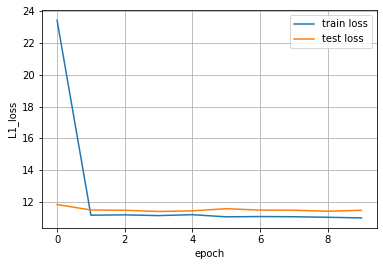

In [105]:
plt.figure()
plt.plot(model_nn_trained[1],  label="train loss")
plt.plot(model_nn_trained[2],  label="test loss")
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("L1_loss")

plt.show()

### 4.4 Another approach, physics principle based methods


There are also other physics principle based methods which can predict protein stabilities such as ESM, EVE and Rosetta etc., without using the provided training set.\newline

        
What's interesting is these approach are more likely to get higher scores over 0.2, better than models trained based on given train\_dataset, which would be discussed later.

Maybe a better approach is combine outsourse data with physics theorems, and totally drop the given train dataset because the differences between train and test proteins is actually large.

#### 4.4.1 a good example
from CHRIS DEOTTE, current 1st (acc. 0.823) in the leaderbord. The notebook he shared 1 month ago gets a score of 0.6, see https://www.kaggle.com/code/cdeotte/difference-features-lb-0-600#EDA-Structure-Difference

: for each test mutation we compute the difference between pLDDT mutation minus pLDDT wildtype. We notice that this submission is very diverse from the existing public notebooks (which mainly focus on wild type protein).

#### 4.4.2 part of his work, no need to run the following

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
from scipy.stats import rankdata

In [ ]:
# basically they working on features only on test dataset and drop train dataset
test = pd.read_csv('../input/novozymes-enzyme-stability-prediction/test.csv')
deletions = test.loc[test.protein_sequence.str.len()==220,'seq_id'].values
test.head()

In [ ]:
# LOAD TEST WILDTYPE
base = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'
len(base)

In [ ]:
# Yu: we also have a trial on train dataset
def get_test_mutation(row):
    for i,(a,b) in enumerate(zip(row.protein_sequence,base)):
        if a!=b: break
    row['wildtype'] = base[i]
    row['mutation'] = row.protein_sequence[i]
    row['position'] = i+1
    return row
test = test.apply(get_test_mutation,axis=1)
test.loc[test.seq_id.isin(deletions),'mutation'] = '_'
test.head()

In [ ]:
# Load PDBs Provided by Kvigly
# EDA Structure Difference
# EDA pLDDT Difference
# Compute Difference Mutation vs. Wild Type Feature
# Create Submission CSV

In [ ]:
# try to get a prediction
preds_final = rf_random.predict(data_test.drop(columns=["seq_id", "protein_sequence"]))
preds_final

array([52.8643484 , 52.77468619, 52.80806179, ..., 53.12768857,
       53.02009609, 53.03263147])

## 5 Submission

The main features in our model are the individual amino acids. The test set consists of just one protein with lots of small mutations, so there is very little variation in the numbers of individual amino acids.

In [107]:
# trying to get a prediction via NN
nn_test = data_test[["protein_sequence", "pH", "data_source"]]
nn_test = protein_length_lim(nn_test)
nn_test = encode(nn_test)
nn_test.head()

,pH,data_source,0,1,2,3,4,5,6,7,...,211,212,213,214,215,216,217,218,219,220
0,8,1,4,15,4,7,15,8,15,18,...,10,7,7,10,2,7,17,4,11,10
1,8,1,4,15,4,7,15,8,15,18,...,10,7,7,10,2,7,17,4,11,10
2,8,1,4,15,4,7,15,8,15,18,...,7,7,10,2,7,17,4,11,10,0
3,8,1,4,15,4,7,15,8,15,18,...,10,7,7,10,2,7,17,4,11,10
4,8,1,4,15,4,7,15,8,15,18,...,10,7,7,10,2,7,17,4,11,10


In [111]:
num_test = nn_test.shape[0]
test_ds_nn = torch.tensor((nn_test[:num_test].values), dtype=torch.long)

In [113]:
output_nn = model_nn(test_ds_nn.to(device)).to(device)

In [116]:
df_preds_nn = output_nn.cpu().data.numpy()
preds_final_nn = pd.DataFrame(df_preds_nn, columns=['tm'])

In [129]:
# also trying to get a submission via lgbm
nn_test_lgbm = data_test.drop(columns=["seq_id", "protein_sequence"])

In [131]:
preds_final_lgbm = gs_lgbm.predict(nn_test_lgbm)

In [133]:
sub = pd.read_csv("/content/drive/MyDrive/after intermediate/sample_submission.csv")
sub.head()

,seq_id,tm
0,31390,0
1,31391,1
2,31392,2
3,31393,3
4,31394,4


In [117]:
# with a score of 0.02, well... better than nothing
from scipy.stats import rankdata
sub["tm"] = preds_final_nn
sub["tm"] = rankdata(sub["tm"])
sub.to_csv('submission1.csv', index=False)


In [132]:
# with a score of 0.16, do have some boosts comparing with ver.1.5
sub["tm"] = preds_final_lgbm
sub["tm"] = rankdata(sub["tm"])
sub.to_csv('submission2.csv', index=False)

## 6 Results & Discussion

### 6.1 why model performs bad in the submission part

The following are potencial reasons why our model performs significantly worse in the submission part in midterm report:
1. lacking of further discussion for the protein_sequence **, checked**;
2. lacking of more features (external dataset) conducted by the biologists and computer scientists **, checked**;
3. the model itself is poorly constructed **, checked**;
4. there's some tricks beneath the test dataset, sepcifically **, exactly!**:


From the above data processing and modeling we've tried to solve the first three potencial reasons, which leads to the forth more suspectable. Remember, the test set contains experimental melting temperature of over 2,413 single-mutation variant of an enzyme (GenBank: KOC15878.1), obtained by Novozymes A/S. Actually the test sample's are highly similar, and much differs from the train dataset, sepcificially:

#### 6.1.1 only one pH values in test data

In [ ]:
data_test["pH"].value_counts()

8    2413
Name: pH, dtype: int64

#### 6.1.2 all test data contain and from the same data source

In [ ]:
data_test["data_source"].value_counts()

1    2413
Name: data_source, dtype: int64

#### 6.1.3 the length in test data is very similar

In [ ]:
data_test["length"].value_counts()

#### 6.1.4 the protein sequence in test dataset is very alike, or otherwise, only differs form mutation or deletion point

The main feature of our model is from protein sequence. The test data contains only protein sequences with many small mutations in amino acid, so the number of individual amino acids changes very little.

In [ ]:
data_test["protein_sequence"]

0       VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...
1       VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...
2       VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...
3       VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...
4       VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...
                              ...                        
2408    VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...
2409    VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...
2410    VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...
2411    VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...
2412    VPVNPEPDATSVENVWLKTGSGDSQSDPIKADLEVKGQSALPFDVD...
Name: protein_sequence, Length: 2413, dtype: object

### 6.2 Results

What's more, we've already found in empirical researches, lots of participants using physics principle based methodes and merely drop train dataset and get a score of about 0.4 recently.

However, consider such differences, our model do have good performance on validation with a score of about 0.2 in submission, which indicates our model do detect some of the mutation features within protein sequence that related to stability.



#### 6.2.1 a brief review
Then let's take a brief review of what we have done in this project. For the intro we find the factors that may influent the protein stability, focuing on protein sequence, we construct feuture engineering to unearth several potencial factors within protein sequence, then construce several fundamantal models: KNeighbors, RandomForest, SVM, LinearRegression, LGBMRegressor and XGBRegressor as our baseline. From there LinearRegression and SVM perform mutch worse then the other four in R2 sense.

Then we discuss the better hyperparameter for the better four models using grid search. After we try to combine models for ensemble, and tuned hyperparameters with randomized search, one ensemble for knn and lgbm as trial and another, and xgb and lgbm for improvements. Combining with these two ensembles with the above four tuned models, comparing in a R2, MAE, MSE sense, actually merely the tuned LGBMRegressor performs the best. 

Furthermore, we try to introduce NN for training using torch. to have another viewpoint on the protein sequence by new feature engineering, to see protein sequence that with sepcific order rather than statistical features and protein pairs. And the result indicates this approach is somewhat better than the above models in MSE sense.


6.2.2 pros and cons

* pros:
    * detailed data preprocessing procedure, feature engineering is interesting and somewhat inspring;
    * abundant models with comparison, with NN as well.

* cons:
    * models evaluation should be more sepcific;
    * lots of futher discussion should be on NN;
    * lacking of deeper biological field knowledge which could inspir model construction;
    * cannot get price, 1st Place - $ 12,000!


### 6.3 Comment

basically that's the end of my work, thanks for your attention. 